In [ ]:
# Core libs
#!pip -q install scikit-learn==1.5.1 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.0

# Tiny NN + compression
#!pip -q install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1
#!pip -q install tensorflow==2.15.1 tensorflow-model-optimization==0.8.0

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Configuration & Reproducibility


In [2]:
from pathlib import Path
import numpy as np, random, os

CFG = {
    "CSV_PATH": "/content/drive/MyDrive/Datasets/Ton-IoT/train_test_network.csv",
    "LABEL_CANDIDATES": ["label", "Label", "attack", "is_attack", "target"],
    "CARDINALITY_LIMIT": 50,     # keep One-Hot only for categoricals with <= 50 unique values
    "K_FEATURES": 32,            # SelectKBest features; ablate with 16/32/48 later
    "SEED": 42,
}

np.random.seed(CFG["SEED"]); random.seed(CFG["SEED"]); os.environ["PYTHONHASHSEED"] = str(CFG["SEED"])


## 2) Load & Inspect the Dataset


In [3]:
import pandas as pd, numpy as np

CSV_PATH = Path(CFG["CSV_PATH"]); assert CSV_PATH.exists(), f"Not found: {CSV_PATH}"
df = pd.read_csv(CSV_PATH, low_memory=False)
print("Shape:", df.shape)
df.head(3)


Shape: (211043, 44)


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


# EDA Visualizations

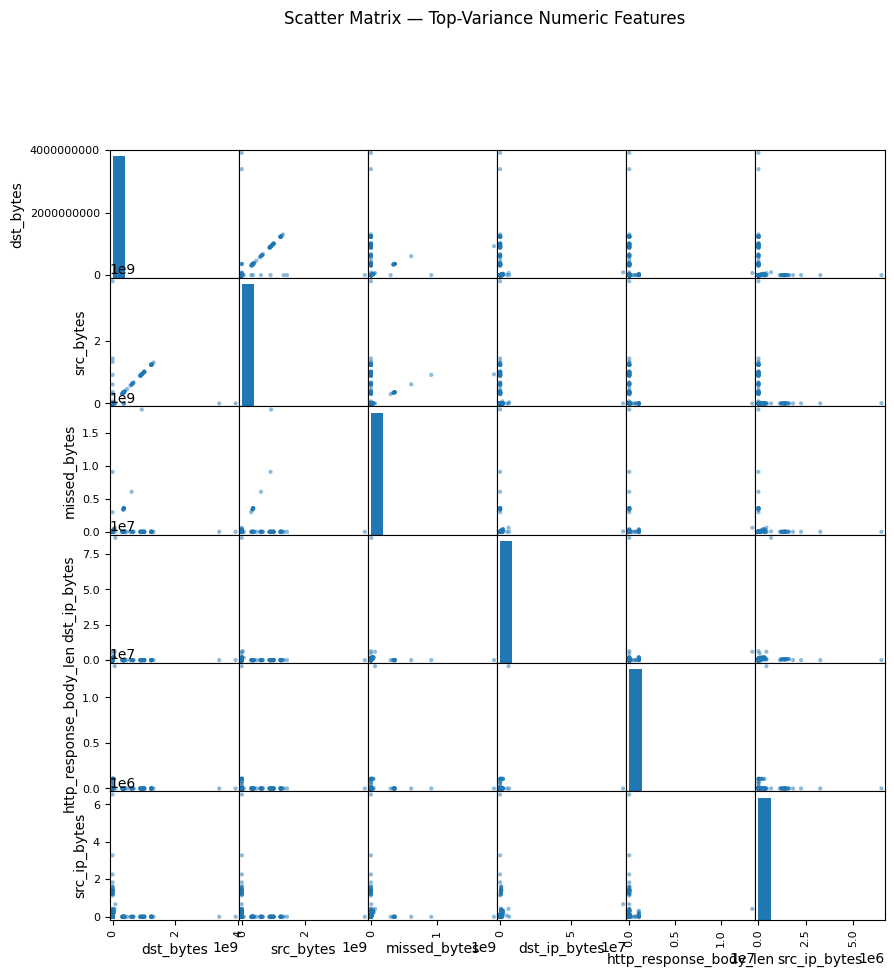

In [15]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import VarianceThreshold

# Build numeric df
num_df = df.select_dtypes(include=[np.number]).copy()
if label_col in num_df.columns:
    num_df = num_df.drop(columns=[label_col])

if len(num_df.columns) >= 2:
    vt = VarianceThreshold()
    _ = vt.fit(num_df)
    variances = pd.Series(vt.variances_, index=num_df.columns).sort_values(ascending=False)
    top = variances.head(min(6, len(variances))).index.tolist()
    sm_df = df[top + [label_col]].copy()
    axes = scatter_matrix(sm_df[top], figsize=(10,10), diagonal='hist')
    plt.suptitle("Scatter Matrix — Top-Variance Numeric Features", y=1.02)
    plt.show()
else:
    print("Not enough numeric columns for scatter matrix.")


/tmp/ipython-input-829630896.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Normal(0)','Attack(1)'], showfliers=False)


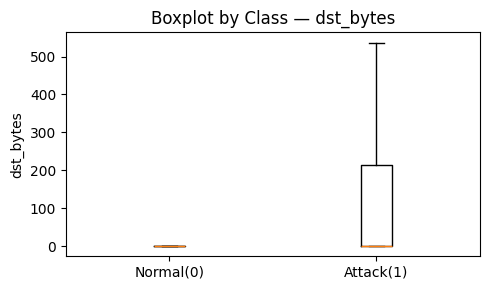

/tmp/ipython-input-829630896.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Normal(0)','Attack(1)'], showfliers=False)


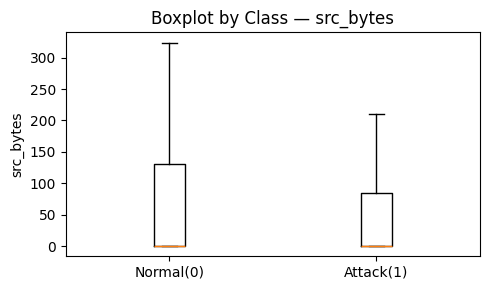

/tmp/ipython-input-829630896.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Normal(0)','Attack(1)'], showfliers=False)


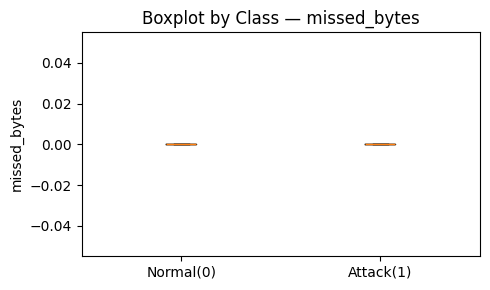

/tmp/ipython-input-829630896.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Normal(0)','Attack(1)'], showfliers=False)


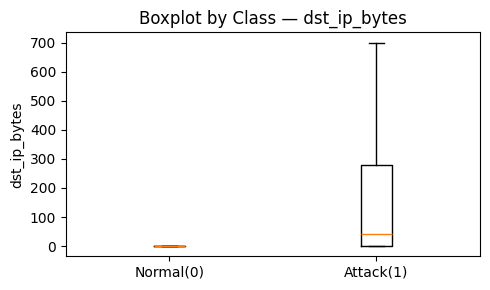

/tmp/ipython-input-829630896.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Normal(0)','Attack(1)'], showfliers=False)


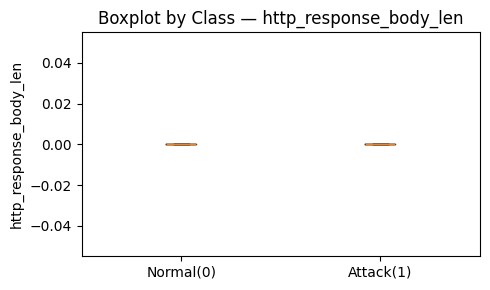

/tmp/ipython-input-829630896.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Normal(0)','Attack(1)'], showfliers=False)


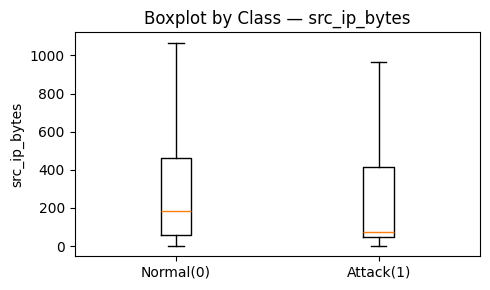

In [16]:
import matplotlib.pyplot as plt

if len(num_df.columns) > 0:
    top_box = variances.head(min(6, len(variances))).index.tolist()
    for col in top_box:
        plt.figure(figsize=(5,3))
        data0 = df[df[label_col]==0][col].dropna()
        data1 = df[df[label_col]==1][col].dropna()
        plt.boxplot([data0, data1], labels=['Normal(0)','Attack(1)'], showfliers=False)
        plt.title(f"Boxplot by Class — {col}")
        plt.ylabel(col)
        plt.tight_layout(); plt.show()


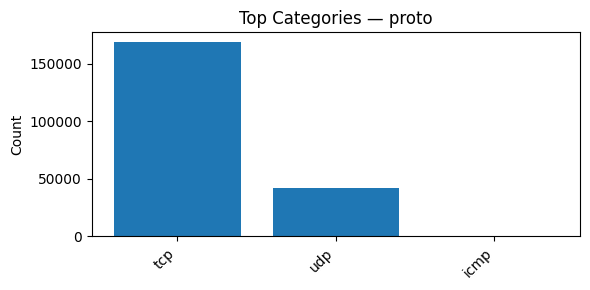

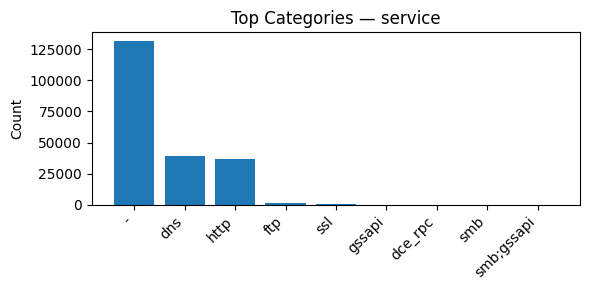

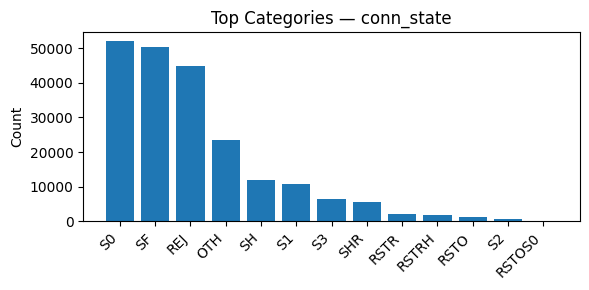

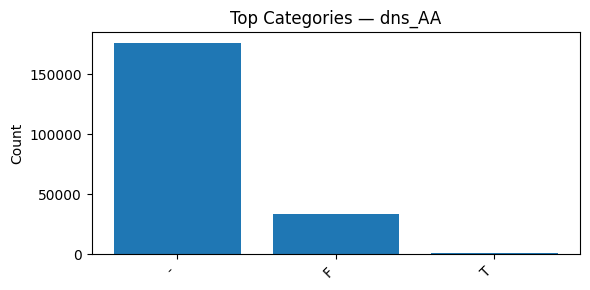

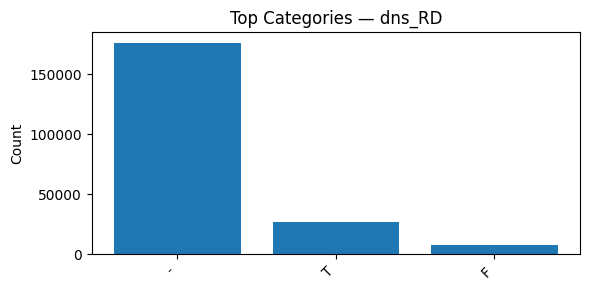

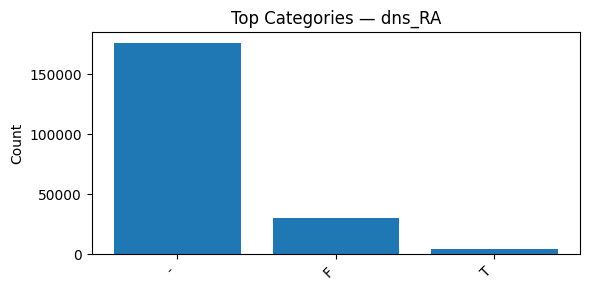

In [17]:
# Show bar plots for up to 6 compact categorical columns (<=50 uniques) kept in preprocessing
obj_cols_all = [c for c in df.columns if df[c].dtype=='object']
compact_cats = [c for c in obj_cols_all if df[c].nunique() <= 50]
compact_cats = compact_cats[:6]

import matplotlib.pyplot as plt
for c in compact_cats:
    vc = df[c].value_counts().head(20)
    plt.figure(figsize=(6,3))
    plt.bar(vc.index.astype(str), vc.values)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top Categories — {c}")
    plt.ylabel("Count")
    plt.tight_layout(); plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

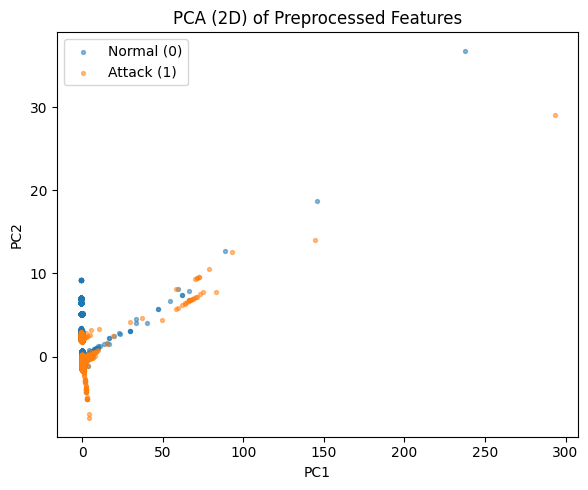

In [18]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline as SkPipeline

prep_only = SkPipeline([('pre', pre), ('sel', selector)]).fit(X_train, y_train)
X_train_small = prep_only.transform(X_train)
X_train_small = X_train_small.toarray() if hasattr(X_train_small, "toarray") else X_train_small

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_train_small)

plt.figure(figsize=(6,5))
mask0 = (y_train.values==0); mask1 = ~mask0
plt.scatter(Z[mask0,0], Z[mask0,1], s=8, alpha=0.5, label='Normal (0)')
plt.scatter(Z[mask1,0], Z[mask1,1], s=8, alpha=0.5, label='Attack (1)')
plt.title("PCA (2D) of Preprocessed Features")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout(); plt.show()


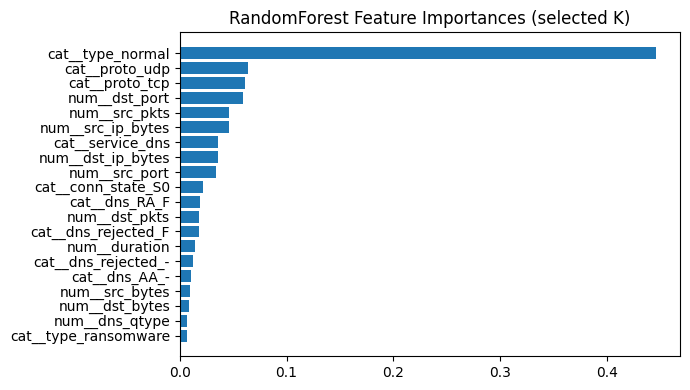

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rf_pipe = globals().get('trained', {}).get('RF')
if rf_pipe is not None:
    pre_fitted = rf_pipe.named_steps['pre']
    sel_fitted = rf_pipe.named_steps['sel']
    clf = rf_pipe.named_steps['clf']

    # names after preprocessor
    try:
        feat_names = pre_fitted.get_feature_names_out()
    except Exception:
        feat_names = np.array([f'f{i}' for i in range(pre_fitted.transform(X_train).shape[1])])

    # selected names
    support = sel_fitted.get_support()
    selected_names = np.array(feat_names)[support]

    importances = getattr(clf, 'feature_importances_', None)
    if importances is not None and len(importances)==len(selected_names):
        topN = min(20, len(importances))
        idx = np.argsort(importances)[-topN:][::-1]
        plt.figure(figsize=(7,4))
        plt.barh(range(topN), importances[idx][::-1])
        plt.yticks(range(topN), selected_names[idx][::-1])
        plt.title("RandomForest Feature Importances (selected K)")
        plt.tight_layout(); plt.show()
    else:
        print("RF importances not available or length mismatch.")
else:
    print("RF model not found in 'trained'.")


**Detect label & optional type; basic cleaning**


In [4]:
# Find label column
label_col = next((c for c in CFG["LABEL_CANDIDATES"] if c in df.columns), None)
assert label_col, f"Could not find a label column in: {df.columns.tolist()}"

# Coerce to 0/1
df[label_col] = pd.to_numeric(df[label_col], errors='coerce')
if set(df[label_col].dropna().unique()) - {0,1}:
    df[label_col] = df[label_col].map({
        'Normal':0,'normal':0,'BENIGN':0,'benign':0,
        'Attack':1,'attack':1,'MALICIOUS':1,'malicious':1
    }).fillna(df[label_col])
    df[label_col] = df[label_col].astype(int)

# Optional attack type
type_col = 'type' if 'type' in df.columns else None

# Clean infinities/NaNs
df = df.replace([np.inf, -np.inf], np.nan).dropna()

print("Rows after clean:", len(df))
print("Class balance (%):", (df[label_col].value_counts(normalize=True)*100).round(2).to_dict())


Rows after clean: 211043
Class balance (%): {1: 76.31, 0: 23.69}


## 3) Train/Test Split & Preprocessing (Scaling + Compact One-Hot)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Respect built-in split if present
split_col = next((c for c in ['subset','train_test','split'] if c in df.columns), None)

y = df[label_col].astype(int)
X = df.drop(columns=[label_col])

if split_col:
    tr_idx = df[split_col].astype(str).str.lower().str.contains('train')
    te_idx = df[split_col].astype(str).str.lower().str.contains('test')
    X_train, X_test = X[tr_idx], X[te_idx]
    y_train, y_test = y[tr_idx], y[te_idx]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=CFG["SEED"]
    )

# Keep only compact categoricals (≤ CARDINALITY_LIMIT)
obj_cols = [c for c in X_train.columns if X_train[c].dtype=='object']
compact_cats = [c for c in obj_cols if X_train[c].nunique() <= CFG["CARDINALITY_LIMIT"]]
X_train = X_train.drop(columns=list(set(obj_cols) - set(compact_cats)))
X_test  = X_test.drop(columns=list(set(obj_cols) - set(compact_cats)))

num_cols = [c for c in X_train.columns if X_train[c].dtype!='object']
cat_cols = [c for c in X_train.columns if X_train[c].dtype=='object']

# OneHotEncoder compatibility across sklearn versions
from sklearn import __version__ as skver
from packaging.version import parse
ohe_kwargs = dict(handle_unknown='ignore')
if parse(skver) >= parse('1.2'):
    ohe_kwargs['sparse_output'] = True
else:
    ohe_kwargs['sparse'] = True
ohe = OneHotEncoder(**ohe_kwargs)

pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), num_cols),
        ('cat', ohe, cat_cols)
    ],
    remainder='drop'
)

print({"num_cols": len(num_cols), "cat_cols": len(cat_cols)})


{'num_cols': 16, 'cat_cols': 23}


## 4) Compact Feature Selection (Mutual Information)


In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
K = CFG["K_FEATURES"]
selector = SelectKBest(mutual_info_classif, k=K)


## 5) Baseline Models (DT / RF / Linear SVM / MLP) + Core Metrics


In [7]:
import io, time, pickle, psutil
import numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

models = {
    'DT': DecisionTreeClassifier(max_depth=10, random_state=CFG["SEED"], class_weight='balanced'),
    'RF': RandomForestClassifier(n_estimators=120, max_depth=12, n_jobs=-1, random_state=CFG["SEED"], class_weight='balanced'),
    'SVM': LinearSVC(C=1.0, random_state=CFG["SEED"], class_weight='balanced'),
    'MLP': MLPClassifier(hidden_layer_sizes=(64,), max_iter=30, random_state=CFG["SEED"]),
}

results = []
trained = {}
for name, est in models.items():
    pipe = Pipeline([('pre', pre), ('sel', selector), ('clf', est)])
    t0 = time.time(); pipe.fit(X_train, y_train); fit_s = time.time()-t0

    # Latency: ms/sample (CPU) over a small batch
    n = min(1000, len(X_test))
    t1 = time.time(); _ = pipe.predict(X_test.iloc[:n]); dt = (time.time()-t1)
    ms_per_sample = (dt*1000)/n

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp/(fp+tn+1e-9)

    buf = io.BytesIO(); pickle.dump(pipe, buf)
    size_kb = len(buf.getvalue())/1024

    results.append(dict(model=name, acc=acc, fpr=fpr, latency_ms=ms_per_sample,
                        size_kb=size_kb, fit_s=fit_s))
    trained[name] = pipe

pd.DataFrame(results).sort_values(['latency_ms','size_kb'])


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

,model,acc,fpr,latency_ms,size_kb,fit_s
2,SVM,0.999976,0.0,0.016082,8.716797,9.690405
3,MLP,0.999976,0.0,0.016088,83.318359,18.913028
0,DT,1.000000,0.0,0.016160,9.417969,6.870103
1,RF,1.000000,0.0,0.060009,1348.416992,20.588992


**Threshold tuning for probability models to reduce FPR:**


In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

def tune_threshold(pipe, X, y, target_fpr=0.05):
    try:
        proba = pipe.predict_proba(X)[:,1]
    except Exception:
        return None
    best = None
    for thr in np.linspace(0.1,0.9,33):
        y_hat = (proba>=thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
        fpr = fp/(fp+tn+1e-9)
        acc = accuracy_score(y, y_hat)
        if best is None or (fpr <= target_fpr and acc > best['acc']):
            best = dict(threshold=float(thr), acc=float(acc), fpr=float(fpr))
    return best

best_rf = tune_threshold(trained['RF'], X_test, y_test, target_fpr=0.05)
best_mlp = tune_threshold(trained['MLP'], X_test, y_test, target_fpr=0.05)
print('RF tuned:', best_rf) ; print('MLP tuned:', best_mlp)


RF tuned: {'threshold': 0.2, 'acc': 1.0, 'fpr': 0.0}
MLP tuned: {'threshold': 0.1, 'acc': 0.9999763083702528, 'fpr': 0.0}


## 6) Lightweight Neural Models + Compression (Pruning + INT8)


### 6a) Tiny PyTorch MLP to Pruning + Dynamic Quantization (INT8)


In [9]:
import torch, torch.nn as nn, torch.nn.functional as F
from sklearn import pipeline as skpipe
from sklearn.metrics import confusion_matrix

# Transform data to compact numeric arrays
prep_only = skpipe.Pipeline([('pre', pre), ('sel', selector)]).fit(X_train, y_train)
Xtr = prep_only.transform(X_train)
Xte = prep_only.transform(X_test)
Xtr = Xtr.toarray().astype('float32') if hasattr(Xtr, "toarray") else Xtr.astype('float32')
Xte = Xte.toarray().astype('float32') if hasattr(Xte, "toarray") else Xte.astype('float32')

ytr_t = torch.tensor(y_train.values, dtype=torch.long)
yte_t = torch.tensor(y_test.values, dtype=torch.long)

class TinyMLP(nn.Module):
    def __init__(self, d_in, d_h=64, d_out=2):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_h)
        self.fc2 = nn.Linear(d_h, d_out)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

net = TinyMLP(Xtr.shape[1], d_h=64, d_out=2)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()
Xt = torch.tensor(Xtr) ; Xv = torch.tensor(Xte)

for epoch in range(10):
    opt.zero_grad(); loss = ce(net(Xt), ytr_t); loss.backward(); opt.step()

# Prune 30% of first layer weights
import torch.nn.utils.prune as prune
prune.l1_unstructured(net.fc1, name='weight', amount=0.3)
prune.remove(net.fc1, 'weight')

# Dynamic quantization
net_q = torch.ao.quantization.quantize_dynamic(net, {nn.Linear}, dtype=torch.qint8)

# Metrics
with torch.no_grad():
    y_pred = net_q(Xv).argmax(1).numpy()
acc = (y_pred == y_test.values).mean()
_tn,_fp,_fn,_tp = confusion_matrix(y_test, y_pred).ravel()
fpr = _fp/(_fp+_tn+1e-9)

# Latency & size
import time, io
n = min(1024, len(Xte))
t0 = time.time(); _ = net_q(torch.tensor(Xte[:n])); dt = time.time()-t0
lat_ms = (dt*1000)/n
buf = io.BytesIO(); torch.save(net_q.state_dict(), buf)
size_kb = len(buf.getvalue())/1024

res_tiny_mlp = {"model":"TinyMLP_INT8_pruned","acc":acc,"fpr":fpr,"latency_ms":lat_ms,"size_kb":size_kb}
res_tiny_mlp


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

{'model': 'TinyMLP_INT8_pruned',
 'acc': np.float64(0.7630837025278969),
 'fpr': np.float64(0.9999999999999),
 'latency_ms': 0.0010989606380462646,
 'size_kb': 5.8876953125}

### 6b) Tiny Keras 1D‑CNN → TFLite INT8


In [10]:
import tensorflow as tf, numpy as np, time
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix

Xtr_cnn = np.expand_dims(Xtr, -1)
Xte_cnn = np.expand_dims(Xte, -1)

inp = keras.Input(shape=(Xtr_cnn.shape[1],1))
x = layers.Conv1D(16, 3, padding='same', activation='relu')(inp)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(16, activation='relu')(x)
out = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inp, out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr_cnn, y_train.values, epochs=5, batch_size=256, validation_split=0.1, verbose=0)

# TFLite dynamic range INT8
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Latency & size
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_idx = interpreter.get_input_details()[0]['index']
output_idx = interpreter.get_output_details()[0]['index']

samples = Xte_cnn[:256]
t0 = time.time()
for i in range(len(samples)):
    interpreter.set_tensor(input_idx, samples[i:i+1])
    interpreter.invoke()
lat_ms = (time.time()-t0)*1000/len(samples)

# Accuracy/FPR
preds = []
for i in range(len(Xte_cnn)):
    interpreter.set_tensor(input_idx, Xte_cnn[i:i+1])
    interpreter.invoke()
    p = interpreter.get_tensor(output_idx)[0][0]
    preds.append(1 if p>=0.5 else 0)

preds = np.array(preds)
acc = (preds == y_test.values).mean()
_tn,_fp,_fn,_tp = confusion_matrix(y_test, preds).ravel()
fpr = _fp/(_fp+_tn+1e-9)
size_kb = len(tflite_model)/1024

res_tiny_cnn = {"model":"Tiny1D-CNN_TFLite_INT8","acc":acc,"fpr":fpr,"latency_ms":lat_ms,"size_kb":size_kb}
res_tiny_cnn


Saved artifact at '/tmp/tmpx66h1n6u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132616512861200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132616512864080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132616512862352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132616512863888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132616512862544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132616512863696: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


{'model': 'Tiny1D-CNN_TFLite_INT8',
 'acc': np.float64(0.9039778246345566),
 'fpr': np.float64(0.31339999999996865),
 'latency_ms': 0.00558607280254364,
 'size_kb': 4.484375}

## 7) Ablations & Threshold Tuning (for thesis rigor)


In [11]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Ablate feature count K
K_list = [16, 32, 48]
abl_rows = []
for K in K_list:
    sel_tmp = SelectKBest(mutual_info_classif, k=K)
    pipe = Pipeline([('pre', pre), ('sel', sel_tmp), ('clf', RandomForestClassifier(n_estimators=120, max_depth=12, n_jobs=-1, random_state=CFG["SEED"], class_weight='balanced'))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    abl_rows.append({"model":"RF","K":K,
                     "acc": accuracy_score(y_test, y_pred),
                     "fpr": fp/(fp+tn+1e-9)})
ablation_df = pd.DataFrame(abl_rows)
ablation_df


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

,model,K,acc,fpr
0,RF,16,1.0,0.0
1,RF,32,1.0,0.0
2,RF,48,1.0,0.0


In [12]:
# Optional: tuned threshold rows (if available from Section 5)
def apply_threshold(pipe, X, thr):
    proba = pipe.predict_proba(X)[:,1]
    return (proba >= thr).astype(int)

thr_rows = []
for name in ['RF','MLP']:
    pipe = trained.get(name)
    if pipe is None:
        continue
    # reuse tune_threshold() from Section 5
    best = tune_threshold(pipe, X_test, y_test, target_fpr=0.05)
    if best:
        import numpy as np
        y_thr = apply_threshold(pipe, X_test, best['threshold'])
        tn, fp, fn, tp = confusion_matrix(y_test, y_thr).ravel()
        thr_rows.append({"model":name+"_tuned","threshold":best['threshold'],
                         "acc": accuracy_score(y_test, y_thr),
                         "fpr": fp/(fp+tn+1e-9)})
pd.DataFrame(thr_rows)


,model,threshold,acc,fpr
0,RF_tuned,0.2,1.000000,0.0
1,MLP_tuned,0.1,0.999976,0.0


## 8) Consolidate Results, Save Tables & Basic Figures


Saved: /content/drive/MyDrive/TON_IoT_artifacts/results_network_toniot.csv
Saved: /content/drive/MyDrive/TON_IoT_artifacts/ablation_rf_K.csv


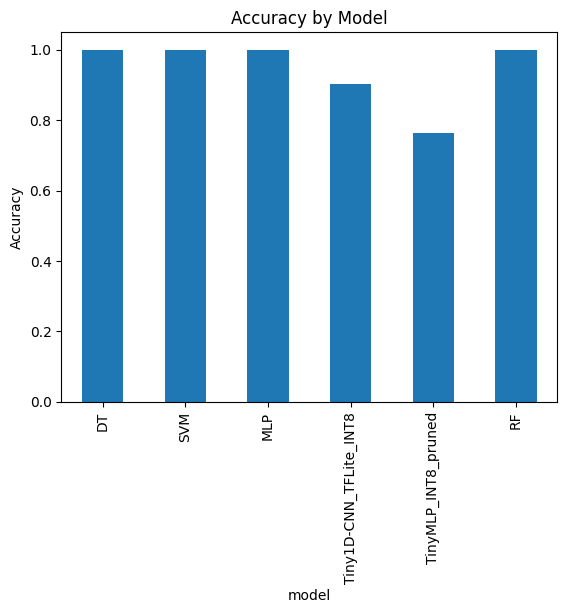

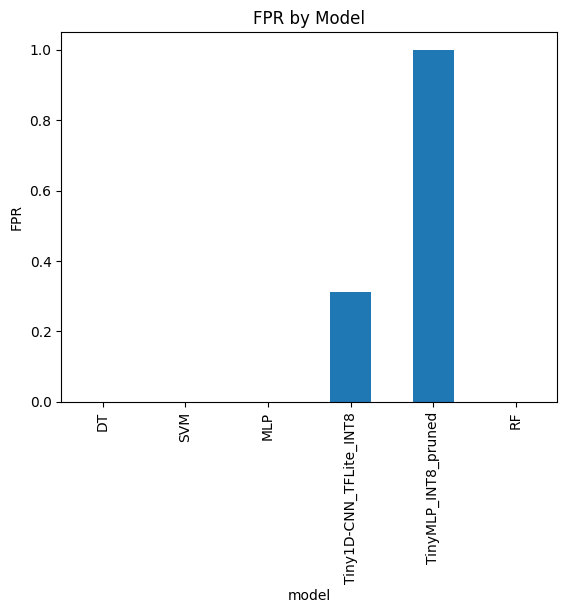

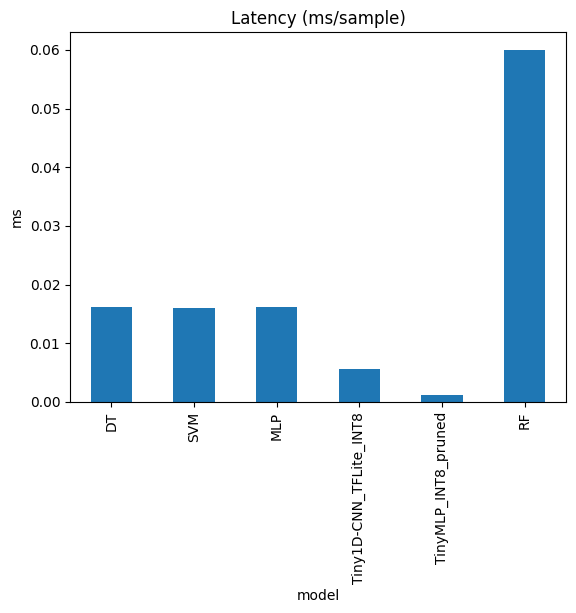

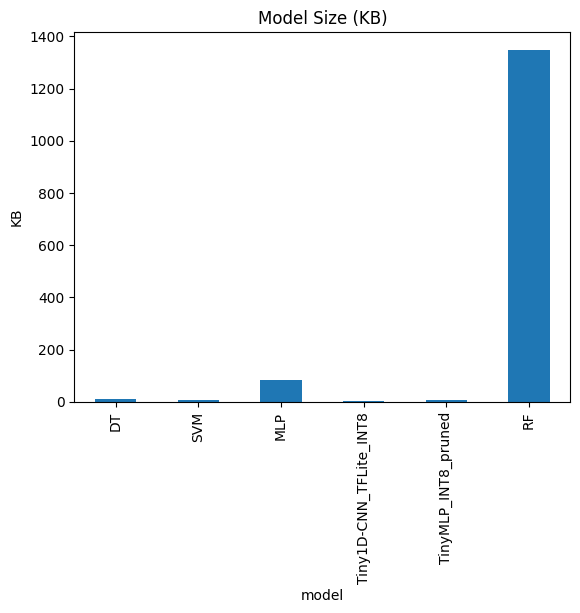

In [13]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

rows = results.copy()
rows.append(res_tiny_mlp)
rows.append(res_tiny_cnn)

df_res = pd.DataFrame(rows)
df_res['meets_latency(<10ms)'] = df_res['latency_ms'] < 10
df_res['meets_size(<200KB)']   = df_res['size_kb'] < 200

df_res_sorted = df_res.sort_values(['meets_latency(<10ms)','meets_size(<200KB)','acc'], ascending=[False, False, False])

a_dir = Path('/content/drive/MyDrive/TON_IoT_artifacts')
a_dir.mkdir(parents=True, exist_ok=True)
(df_res_sorted).to_csv(a_dir/'results_network_toniot.csv', index=False)
(ablation_df).to_csv(a_dir/'ablation_rf_K.csv', index=False)

print("Saved:", a_dir/'results_network_toniot.csv')
print("Saved:", a_dir/'ablation_rf_K.csv')

# Simple figures
plt.figure(); df_res_sorted.set_index('model')['acc'].plot(kind='bar'); plt.title('Accuracy by Model'); plt.ylabel('Accuracy'); plt.show()
plt.figure(); df_res_sorted.set_index('model')['fpr'].plot(kind='bar'); plt.title('FPR by Model'); plt.ylabel('FPR'); plt.show()
plt.figure(); df_res_sorted.set_index('model')['latency_ms'].plot(kind='bar'); plt.title('Latency (ms/sample)'); plt.ylabel('ms'); plt.show()
plt.figure(); df_res_sorted.set_index('model')['size_kb'].plot(kind='bar'); plt.title('Model Size (KB)'); plt.ylabel('KB'); plt.show()


## 9) Export Artifacts for the Thesis Appendix


In [14]:
import pickle, json, io
from pathlib import Path

a_dir = Path('/content/drive/MyDrive/TON_IoT_artifacts')
a_dir.mkdir(parents=True, exist_ok=True)

# Save best baseline model (by latency then size then accuracy)
best_idx = df_res_sorted.index[0]
best_name = df_res_sorted.loc[best_idx, 'model']
best_pipe = trained.get(best_name, None)
if best_pipe is not None:
    with open(a_dir/f'{best_name}.pkl','wb') as f:
        pickle.dump(best_pipe, f)

# Save tiny models
with open(a_dir/'tinymlp_int8_pruned.pt','wb') as f:  # state_dict
    import torch
    torch.save(net_q.state_dict(), f)

# Save TFLite model from Section 6b
with open(a_dir/'tiny1d_cnn_int8.tflite','wb') as f:
    f.write(tflite_model)

report = {
    "csv_path": str(CSV_PATH),
    "features_after_preproc": int(pre.fit_transform(X_train).shape[1]),
    "results_table": str(a_dir/'results_network_toniot.csv'),
    "ablation_table": str(a_dir/'ablation_rf_K.csv'),
    "targets": {"latency_ms":"<10", "size_kb":"<200"}
}
json.dump(report, open(a_dir/'run_report.json','w'), indent=2)
import pprint; pprint.pprint(report)


{'ablation_table': '/content/drive/MyDrive/TON_IoT_artifacts/ablation_rf_K.csv',
 'csv_path': '/content/drive/MyDrive/Datasets/Ton-IoT/train_test_network.csv',
 'features_after_preproc': 162,
 'results_table': '/content/drive/MyDrive/TON_IoT_artifacts/results_network_toniot.csv',
 'targets': {'latency_ms': '<10', 'size_kb': '<200'}}


# Results Visualizations (All Models + Threshold Sweeps)

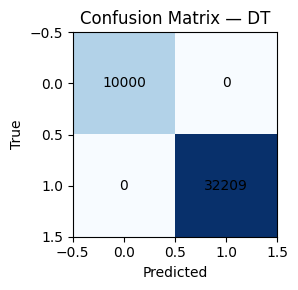

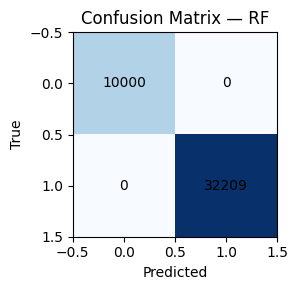

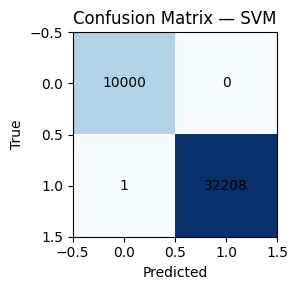

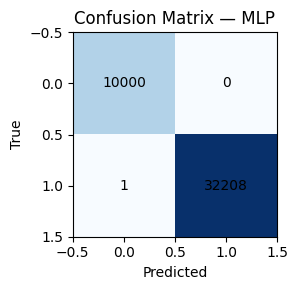

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

def plot_confusion(pipe, name):
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, cmap='Blues')
    for (i,j),v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()

for name, pipe in globals().get('trained', {}).items():
    plot_confusion(pipe, name)


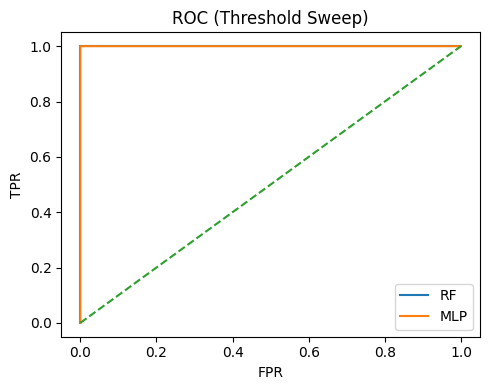

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

def proba_scores(pipe, X):
    try:
        return pipe.predict_proba(X)[:,1]
    except Exception:
        try:
            s = pipe.decision_function(X)
            return (s - s.min())/(s.max()-s.min()+1e-9)
        except Exception:
            return None

plt.figure(figsize=(5,4))
for name in ['RF','MLP']:
    pipe = globals().get('trained', {}).get(name)
    if pipe is None:
        continue
    scores = proba_scores(pipe, X_test)
    if scores is None:
        continue
    fpr, tpr, thr = roc_curve(y_test, scores)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Threshold Sweep)'); plt.legend()
plt.tight_layout(); plt.show()


<Figure size 500x400 with 0 Axes>

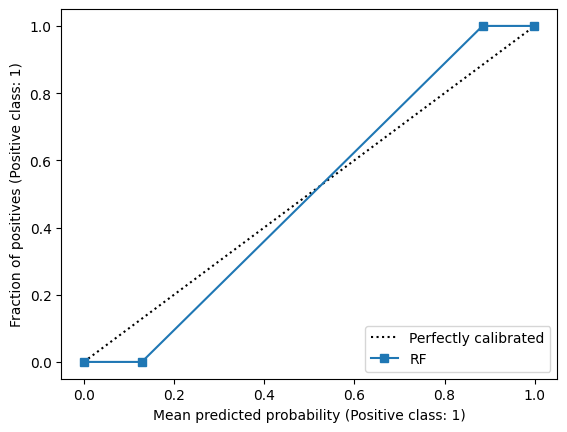

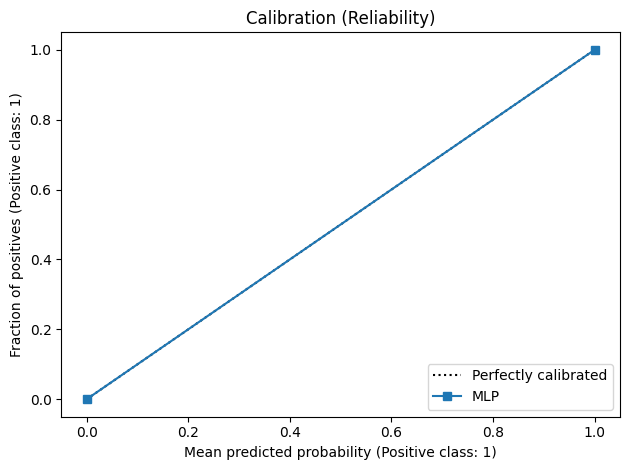

In [22]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

plt.figure(figsize=(5,4))
for name in ['RF','MLP']:
    pipe = globals().get('trained', {}).get(name)
    if pipe is None: continue
    try:
        CalibrationDisplay.from_estimator(pipe, X_test, y_test, n_bins=10, name=name)
    except Exception:
        pass
plt.title('Calibration (Reliability)'); plt.tight_layout(); plt.show()


# Save All Models to Drive (pipelines + tiny models + thresholds)

In [23]:
from pathlib import Path
import pickle, json
a_dir = Path('/content/drive/MyDrive/TON_IoT_artifacts')
a_dir.mkdir(parents=True, exist_ok=True)

# 3.1 Save every baseline pipeline in 'trained'
saved = []
for name, pipe in globals().get('trained', {}).items():
    out = a_dir/f'{name}_pipeline.pkl'
    with open(out, 'wb') as f:
        pickle.dump(pipe, f)
    saved.append(str(out))

# 3.2 Save tuned thresholds if computed
thresholds = {}
for name in ['RF','MLP']:
    best = globals().get(f'best_{name.lower()}', None)  # expects best_rf, best_mlp from main notebook
    if best: thresholds[name] = best
with open(a_dir/'thresholds.json','w') as f:
    json.dump(thresholds, f, indent=2)

# 3.3 Save tiny models
# PyTorch quantized + pruned MLP (state_dict)
net_q = globals().get('net_q', None)
if net_q is not None:
    import torch
    with open(a_dir/'tinymlp_int8_pruned.pt','wb') as f:
        torch.save(net_q.state_dict(), f)

# TFLite CNN file
tflite_model = globals().get('tflite_model', None)
if tflite_model is not None:
    with open(a_dir/'tiny1d_cnn_int8.tflite','wb') as f:
        f.write(tflite_model)

print("Saved model files:", *saved, sep="\n - ")
print("Thresholds file:", a_dir/'thresholds.json')
print("Tiny MLP (pt):", a_dir/'tinymlp_int8_pruned.pt')
print("Tiny CNN (tflite):", a_dir/'tiny1d_cnn_int8.tflite')


Saved model files:
 - /content/drive/MyDrive/TON_IoT_artifacts/DT_pipeline.pkl
 - /content/drive/MyDrive/TON_IoT_artifacts/RF_pipeline.pkl
 - /content/drive/MyDrive/TON_IoT_artifacts/SVM_pipeline.pkl
 - /content/drive/MyDrive/TON_IoT_artifacts/MLP_pipeline.pkl
Thresholds file: /content/drive/MyDrive/TON_IoT_artifacts/thresholds.json
Tiny MLP (pt): /content/drive/MyDrive/TON_IoT_artifacts/tinymlp_int8_pruned.pt
Tiny CNN (tflite): /content/drive/MyDrive/TON_IoT_artifacts/tiny1d_cnn_int8.tflite
